---
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: arrow
  pdf:
    documentclass: scrreprt
    links-as-notes: true
    reference-location: section
    toc: true
    toc-depth: 2
    lof: true
    lot: true
    number-sections: true
    fig-width: 8
    fig-height: 6

---

# Tabu Search for GAP

## Algorithm Design

### Solution representation

### Neighborhood structure

### Tabu table design

## Implementation Details in Java

In this section, we present an implementation of Tabu Search in Java.

### Source file structure

```{.bash}
src/main/java
└── com
    └── voyager
        └── opt
            └── metaheuristics
                ├── gap
                │   ├── GapInstance.java
                │   ├── GapInstanceReader.java
                │   ├── GapSolution.java
                │   └── tabu
                │       ├── GapSolutionNeighbor.java
                │       └── GapTabuSearch.java
                └── utils
                    ├── PerfRecord.java
                    └── PerfRecordsWriter.java
```

### Java classes and explanations


```{.java filename="GapInstance.java"}
package com.voyager.opt.metaheuristics.gap;

import lombok.AllArgsConstructor;
import lombok.Builder;
import lombok.Data;

@Data
@Builder
@AllArgsConstructor
public class GapInstance {
  /**
   * total number of tasks
   */
  private int numTasks;
  /**
   * total number of agents
   */
  private int numAgents;
  /**
   * costs of assigning tasks to agents
   */
  private int[][] costs;
  /**
   * resource consumption of assigning tasks to agents
   */
  private int[][] resources;
  /**
   * agent capacities
   */
  private int[] capacities;
}
```

```{.java filename="GapSolution.java"}
package com.voyager.opt.metaheuristics.gap;

import lombok.Getter;

import java.util.Arrays;
import java.util.Random;
import java.util.stream.IntStream;

@Getter
public final class GapSolution {
  /**
   * reference to the instance to be solved
   */
  private final GapInstance instance;
  /**
   * dimension: 1 * numTasks
   * assigned agent index for each task
   */
  private final int[] agentAssignments;
  /**
   * dimension: 1 * numAgents
   * consumed capacity of each agent
   */
  private final int[] consumedCapacities;
  /**
   * total objective value
   */
  private int objective;
  /**
   * assignment cost, without penalties
   */
  private int assignmentCost;
  /**
   * capacity violation penalties of all agents
   */
  private int capacityViolationPenalty;

  public GapSolution(GapInstance instance) {
    this.instance = instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    Arrays.fill(this.agentAssignments, 0);
    Arrays.fill(consumedCapacities, 0);
    this.objective = 0;
    this.assignmentCost = 0;
    this.capacityViolationPenalty = 0;
  }

  /**
   * copy constructor
   * @param other the other solution to copy from
   */
  public GapSolution(GapSolution other) {
    this.instance = other.instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    System.arraycopy(other.agentAssignments, 0,
      this.agentAssignments, 0,
      this.instance.getNumTasks());
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    System.arraycopy(other.consumedCapacities, 0,
      this.consumedCapacities, 0,
      this.instance.getNumAgents());
    this.objective = other.objective;
    this.assignmentCost = other.assignmentCost;
    this.capacityViolationPenalty = other.capacityViolationPenalty;
  }

  /**
   * randomly assign tasks to agents
   * @param random random number generator
   */
  public void initialize(Random random) {
    int[][] resources = this.instance.getResources();
    for (int i = 0; i < instance.getNumTasks(); i++) {
      int agentIdx = random.nextInt(instance.getNumAgents());
      this.agentAssignments[i] = agentIdx;
      this.consumedCapacities[agentIdx] += resources[agentIdx][i];
    }
  }

  /**
   * compute objective values
   * @param capacityViolationPenalty penalty factor
   */
  public void computeObjective(int capacityViolationPenalty) {
    // compute assignment costs
    this.assignmentCost = IntStream.range(0, instance.getNumTasks())
      .map(taskIdx -> instance.getCosts()[agentAssignments[taskIdx]][taskIdx])
      .sum();

    // compute capacity violation costs
    this.capacityViolationPenalty = IntStream.range(0, instance.getNumAgents())
      .map(agentIdx -> capacityViolationPenalty *
        Math.max(0, this.consumedCapacities[agentIdx] - instance.getCapacities()[agentIdx]))
      .sum();

    this.objective = this.assignmentCost + this.capacityViolationPenalty;
  }

  public int getAssignedAgent(int taskIdx) {
    return this.agentAssignments[taskIdx];
  }

  /**
   * assign agent to task
   * @param taskIdx the task to be assigned
   * @param agentIdx the agent index
   */
  public void setAssignedAgent(int taskIdx, int agentIdx) {
    int currAgentIdx = this.agentAssignments[taskIdx];
    this.agentAssignments[taskIdx] = agentIdx;
    this.consumedCapacities[currAgentIdx] -= instance.getResources()[currAgentIdx][taskIdx];
    this.consumedCapacities[agentIdx] += instance.getResources()[agentIdx][taskIdx];
  }
}
```

```{.java filename="GapSolutionNeighbor.java"}
package com.voyager.opt.metaheuristics.gap.tabu;

import com.voyager.opt.metaheuristics.gap.GapSolution;
import lombok.Builder;
import lombok.Getter;

@Getter
@Builder
public class GapSolutionNeighbor {
  /**
   * neighboring solution
   */
  private GapSolution newSolution;
  /**
   * the task for which agent assignment is changed
   */
  private int mutatedTaskIdx;
  /**
   * new agent index for the chosen task
   */
  private int newAgentIdx;
}
```

```{.java filename="GapTabuSearch"}
package com.voyager.opt.metaheuristics.gap.tabu;

import com.voyager.opt.metaheuristics.gap.GapInstance;
import com.voyager.opt.metaheuristics.gap.GapInstanceReader;
import com.voyager.opt.metaheuristics.gap.GapSolution;
import com.voyager.opt.metaheuristics.utils.PerfRecord;
import com.voyager.opt.metaheuristics.utils.PerfRecordsWriter;
import lombok.Getter;
import lombok.Setter;

import java.util.*;

@Getter
@Setter
public final class GapTabuSearch {
  /**
   * instance to be solved
   */
  private final GapInstance instance;
  /**
   * random number generator
   */
  private final Random random;
  /**
   * tabu table
   */
  private final int[][] tabuTable;
  /**
   * best solution
   */
  private GapSolution bestSolution;
  private List<PerfRecord<Integer>> perfRecords;

  public GapTabuSearch(GapInstance instance) {
    this.instance = instance;
    this.random = new Random(42);
    int numTasks = instance.getNumTasks();
    this.tabuTable = new int[numTasks][instance.getNumAgents()];
    for (int i = 0; i < numTasks; i++) {
      Arrays.fill(this.tabuTable[i], 0);
    }

    this.bestSolution = null;
    this.perfRecords = new ArrayList<>();
  }

  public void solve() {
    // penalty factor for capacity violation
    int capacityViolationPenalty = 1000;

    // tabu search parameters
    int neighSize = 100;
    int tabuLength = 100;

    // stopping criteria
    int maxIter = 2000;
    int maxIterNoImprove = 500;

    // create a starting solution
    GapSolution currSolution = new GapSolution(this.instance);
    currSolution.initialize(this.random);
    currSolution.computeObjective(capacityViolationPenalty);
    this.bestSolution = currSolution;
    this.perfRecords.add(new PerfRecord<>(0,
      currSolution.getObjective(),
      bestSolution.getObjective()));

    int numTasks = this.instance.getNumTasks();
    int numAgents = this.instance.getNumAgents();

    // main workflow
    int iter = 0;
    int iterNoImprove = 0;
    while (true) {
      System.out.println("iter: " + iter + ", best obj: " + bestSolution.getObjective());
      // create neighboring solutions
      List<GapSolutionNeighbor> neighbors = new ArrayList<>(neighSize);
      for (int i = 0; i < neighSize; i++) {
        // create a copy of current solution
        GapSolution newSolution = new GapSolution(currSolution);

        // mutate one task assignment
        int randTaskIdx = this.random.nextInt(numTasks);
        int currAgentIdx = newSolution.getAssignedAgent(randTaskIdx);
        int newAgentIdx = this.random.nextInt(numAgents);
        while (newAgentIdx == currAgentIdx) {
          newAgentIdx = this.random.nextInt(numAgents);
        }
        newSolution.setAssignedAgent(randTaskIdx, newAgentIdx);

        // compute objective value after mutation
        newSolution.computeObjective(capacityViolationPenalty);

        GapSolutionNeighbor neighbor = GapSolutionNeighbor.builder()
          .newSolution(newSolution)
          .mutatedTaskIdx(randTaskIdx)
          .newAgentIdx(newAgentIdx)
          .build();
        neighbors.add(neighbor);
      }

      // sort neighboring solutions
      neighbors.sort(Comparator.comparingInt(neighbor -> neighbor.getNewSolution().getObjective()));

      boolean currSolutionUpdated = false;
      boolean bestSolutionUpdated = false;
      // check tabu criteria
      for (GapSolutionNeighbor neighbor : neighbors) {
        GapSolution newSolution = neighbor.getNewSolution();
        int mutatedTaskIdx = neighbor.getMutatedTaskIdx();
        int newAgentIdx = neighbor.getNewAgentIdx();

        if (this.tabuTable[mutatedTaskIdx][newAgentIdx] < iter) {
          // this move is not tabooed, proceed
          currSolution = newSolution;
          currSolutionUpdated = true;
          this.tabuTable[mutatedTaskIdx][newAgentIdx] = iter + tabuLength;

          if (currSolution.getObjective() < this.bestSolution.getObjective()) {
            this.bestSolution = currSolution;
            bestSolutionUpdated = true;
            break;
          }
        } else {
          // check aspiration criterion
          if (newSolution.getObjective() < bestSolution.getObjective()) {
            currSolution = newSolution;
            bestSolution = currSolution;
            currSolutionUpdated = true;
            bestSolutionUpdated = true;
            this.tabuTable[mutatedTaskIdx][newAgentIdx] = iter + tabuLength;
            break;
          }
        }
      }

      // in case no move is possible, choose the best neighbor
      if (!currSolutionUpdated) {
        GapSolutionNeighbor neighbor = neighbors.getFirst();
        currSolution = neighbor.getNewSolution();
        this.tabuTable[neighbor.getMutatedTaskIdx()][neighbor.getNewAgentIdx()] = iter + tabuLength;
      }

      iter++;
      this.perfRecords.add(new PerfRecord<>(iter,
        currSolution.getObjective(),
        bestSolution.getObjective()));

      // check stopping criteria
      iterNoImprove = bestSolutionUpdated ? 0 : iterNoImprove + 1;
      if (iter >= maxIter || iterNoImprove >= maxIterNoImprove) {
        break;
      }
    }
  }

  public void savePerfRecords(String filename) {
    PerfRecordsWriter.write(filename, perfRecords);
  }

  public static void main(String[] args) {
    String filename = "/Users/klian/dev/metaheuristics-java-code/src/main/resources/data/gap/gap1.txt";
    String outputFilename = "/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records.txt";
    List<GapInstance> instances = GapInstanceReader.read(filename);

    GapInstance instance = instances.get(1);
    GapTabuSearch tabuSearch = new GapTabuSearch(instance);
    tabuSearch.solve();
    tabuSearch.savePerfRecords(outputFilename);
  }
}
```

## Performance Illustration

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records.csv", names=['iteration', 'curr_obj', 'best_obj'])

In [8]:
df

,iteration,curr_obj,best_obj
0,0,79294,79294
1,1,56291,56291
2,2,43294,43294
3,3,32300,32300
4,4,29306,29306
...,...,...,...
554,554,7294,273
555,555,1291,273
556,556,3297,273
557,557,1291,273


(0.0, 80000.0)

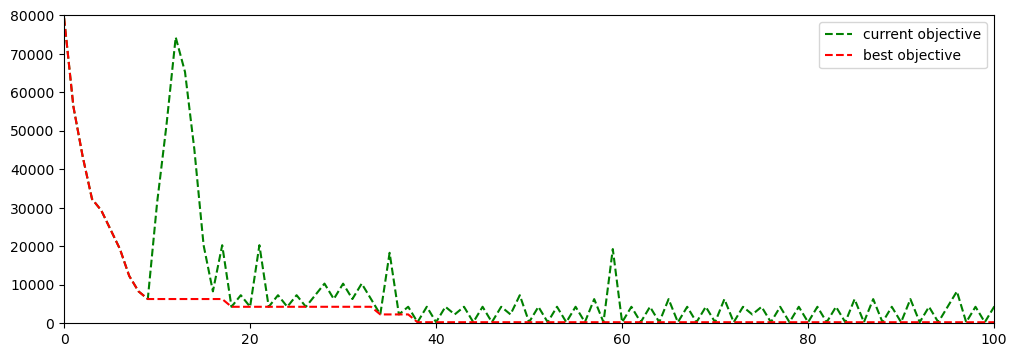

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df['iteration'], df['curr_obj'], 'g--', label="current objective")
ax.plot(df['iteration'], df['best_obj'], 'r--', label="best objective")
ax.legend()

ax.set_xlim([0, 100])
ax.set_ylim([0, 80000])